In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange

In [2]:
os.chdir('../')

In [3]:
%%capture
from nutrition_labels.grant_tagger import GrantTagger

In [4]:
data = pd.read_csv('data/processed/training_data.csv')

(array([ 16.,   5.,   3.,   4.,  10.,  16.,  23.,  51., 114., 368., 427.,
         95.,  43.,  28.,  18.,   7.,   6.,   2.,   2.,  12.,   3.,   1.,
          2.,   2.,   4.,   9.,   2.,   1.,   1.,   4.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([  13. ,  147.4,  281.8,  416.2,  550.6,  685. ,  819.4,  953.8,
        1088.2, 1222.6, 1357. , 1491.4, 1625.8, 1760.2, 1894.6, 2029. ,
        2163.4, 2297.8, 2432.2, 2566.6, 2701. , 2835.4, 2969.8, 3104.2,
        3238.6, 3373. , 3507.4, 3641.8, 3776.2, 3910.6, 4045. , 4179.4,
        4313.8, 4448.2, 4582.6, 4717. , 4851.4, 4985.8, 5120.2, 5254.6,
        5389. , 5523.4, 5657.8, 5792.2, 5926.6, 6061. , 6195.4, 6329.8,
        6464.2, 6598.6, 6733. ]),
 <BarContainer object of 50 artists>)

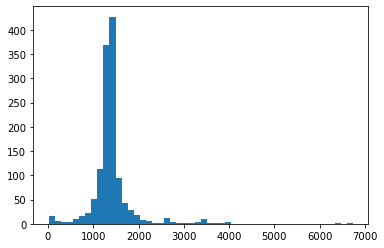

In [5]:
plt.hist(data['Description'].apply(len), bins=50)

In [6]:
len([d for d in data['Description'] if len(d)<500])

25

In [7]:
def run_experiment(sample_not_relevant_range, num_repeats, vectorizer_type,model_type = 'naive_bayes'):
    experiments_results = []
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type
            )
    X_vect,y = grant_tagger.transform(data)
    for n in sample_not_relevant_range:
        average_results_train = None
        average_results_test = None
        for i in range(0, num_repeats):
            # Take the average of 5 runs

            X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                sample_not_relevant = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
            grant_tagger.fit(X_train, y_train)
            results_train = grant_tagger.evaluate(X_train, y_train, print_results=False, average='weighted')
            results_test = grant_tagger.evaluate(X_test, y_test, print_results=False, average='weighted')
            if average_results_train: # will be the same for test too
                for key in average_results_train.keys(): # will be the same for test too
                    average_results_train[key] += results_train[key]
                    average_results_test[key] += results_test[key]
            else:
                average_results_train = results_train
                average_results_test = results_test
        average_results_train = {key: value/num_repeats for key, value in average_results_train.items()}
        average_results_test = {key: value/num_repeats for key, value in average_results_test.items()}
        results_dict = {'sample_not_relevant': n}
        for key, value in average_results_train.items():
            results_dict[key+'_train'] = value
        for key, value in average_results_test.items():
            results_dict[key+'_test'] = value
        experiments_results.append(results_dict)
        
    return experiments_results

In [8]:
def plot_results(experiments_results_df):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_train',ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_test', color='red', ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_train',ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_test', color='red', ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_train',ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_test', color='red', ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_train',ax=ax4, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_test', color='red', ax=ax4, marker='.')
    # fig.savefig(f'sample_not_relevant_{num_repeats}reps_{vectorizer_type}.png')
    # plt.close(fig)
    plt.show()

In [9]:
count_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='count'
)

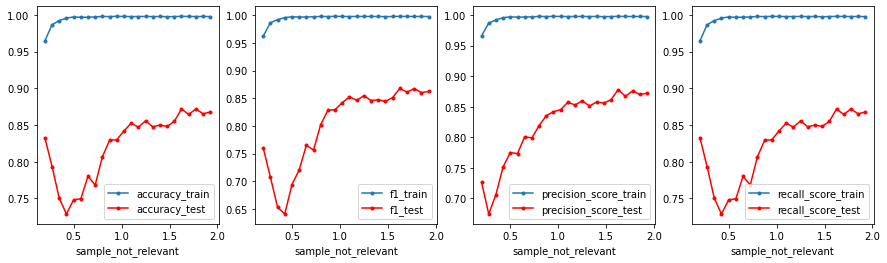

In [10]:
experiments_results_df = pd.DataFrame(count_experiments_results)
plot_results(experiments_results_df)

In [11]:
tfidf_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='tfidf'
)

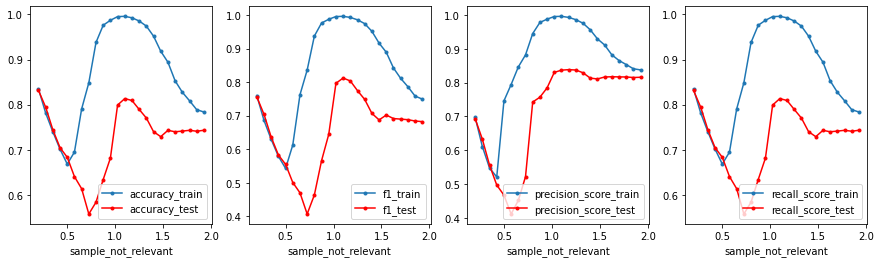

In [12]:
experiments_results_df = pd.DataFrame(tfidf_experiments_results)
plot_results(experiments_results_df)

In [13]:
print(len(data.loc[data['Relevance code'] == 1]))
print(len(data.loc[data['Relevance code'] == 0]))

292
989


## Explore all the results of those with good parameters

In [14]:
def test_setting(data, vectorizer_type, n, model_type = 'naive_bayes'):
    i = 4
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type
            )
    X_vect,y = grant_tagger.transform(data)
    X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                sample_not_relevant = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
    grant_tagger.fit(X_train, y_train)
    results_train = grant_tagger.evaluate(X_train, y_train, average='weighted')
    results_test = grant_tagger.evaluate(X_test, y_test, average='weighted')

In [15]:
test_setting(data, 'tfidf', 40)

{'accuracy': 0.8125, 'f1': 0.7567232572115384, 'precision_score': 0.8491052060737527, 'recall_score': 0.8125}
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       742
           1       1.00      0.17      0.30       218

    accuracy                           0.81       960
   macro avg       0.90      0.59      0.59       960
weighted avg       0.85      0.81      0.76       960

              predicted tag 0  predicted tag 1
actual tag 0              742                0
actual tag 1              180               38
{'accuracy': 0.8006230529595015, 'f1': 0.7361037336919158, 'precision_score': 0.8416523925433983, 'recall_score': 0.8006230529595015}
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       247
           1       1.00      0.14      0.24        74

    accuracy                           0.80       321
   macro avg       0.90      0.57      0.56       321
weighted avg    

In [16]:
test_setting(data, 'tfidf', 320)

{'accuracy': 0.8125, 'f1': 0.7567232572115384, 'precision_score': 0.8491052060737527, 'recall_score': 0.8125}
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       742
           1       1.00      0.17      0.30       218

    accuracy                           0.81       960
   macro avg       0.90      0.59      0.59       960
weighted avg       0.85      0.81      0.76       960

              predicted tag 0  predicted tag 1
actual tag 0              742                0
actual tag 1              180               38
{'accuracy': 0.8006230529595015, 'f1': 0.7361037336919158, 'precision_score': 0.8416523925433983, 'recall_score': 0.8006230529595015}
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       247
           1       1.00      0.14      0.24        74

    accuracy                           0.80       321
   macro avg       0.90      0.57      0.56       321
weighted avg    

In [17]:
test_setting(data, 'count', 40)

{'accuracy': 0.9979166666666667, 'f1': 0.9979132683334264, 'precision_score': 0.9979222670250896, 'recall_score': 0.9979166666666667}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       742
           1       1.00      0.99      1.00       218

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

              predicted tag 0  predicted tag 1
actual tag 0              742                0
actual tag 1                2              216
{'accuracy': 0.8940809968847352, 'f1': 0.8862844928566966, 'precision_score': 0.8946051890425447, 'recall_score': 0.8940809968847352}
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.90      0.61      0.73        74

    accuracy                           0.89       321
   macro avg       0.90      0.79      0.83   

In [18]:
test_setting(data, 'count', 400)

{'accuracy': 0.9979166666666667, 'f1': 0.9979132683334264, 'precision_score': 0.9979222670250896, 'recall_score': 0.9979166666666667}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       742
           1       1.00      0.99      1.00       218

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

              predicted tag 0  predicted tag 1
actual tag 0              742                0
actual tag 1                2              216
{'accuracy': 0.8940809968847352, 'f1': 0.8862844928566966, 'precision_score': 0.8946051890425447, 'recall_score': 0.8940809968847352}
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.90      0.61      0.73        74

    accuracy                           0.89       321
   macro avg       0.90      0.79      0.83   

## Testing Bert Vectorizer


Bert and Naive Bayes model


In [19]:
%%capture
bert_bayes_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=5, vectorizer_type='bert'
)


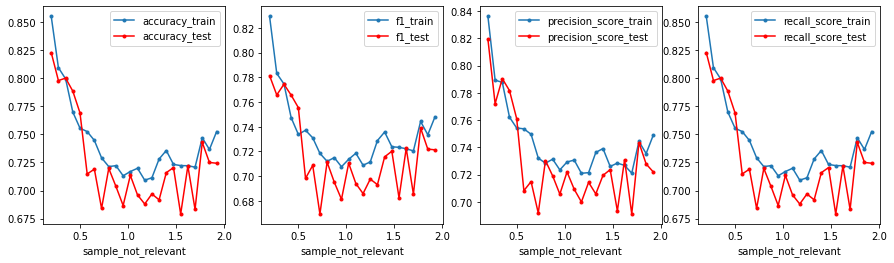

In [20]:
experiments_results_df = pd.DataFrame(bert_bayes_experiments_results)
plot_results(experiments_results_df)

Bert and SVM model


In [21]:
%%capture
bert_svm_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=5, vectorizer_type='bert', model_type='SVM'
)


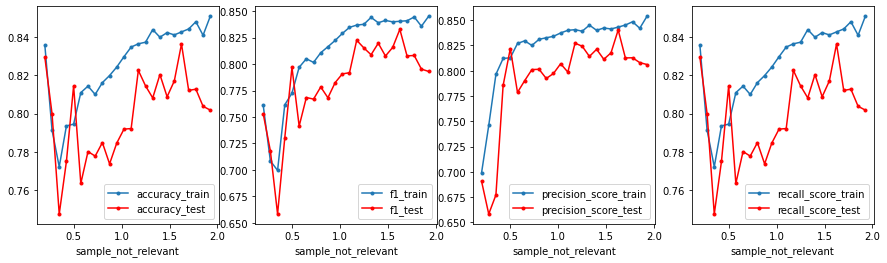

In [22]:
experiments_results_df = pd.DataFrame(bert_svm_experiments_results)
plot_results(experiments_results_df)

Bert and Logistic regression model


In [ ]:
%%capture
bert_logreg_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=5, vectorizer_type='bert', model_type='log_reg'
)


In [ ]:
experiments_results_df = pd.DataFrame(bert_logreg_experiments_results)
plot_results(experiments_results_df)

## Exploring Bert Results with good parameters 

In [ ]:
test_setting(data, 'bert', 40)

In [ ]:
test_setting(data, 'bert', 360)

In [ ]:
test_setting(data, 'bert', 40,'SVM')

In [ ]:
test_setting(data, 'bert', 360,'SVM')

test_setting(data, 'bert', 360,'SVM')

In [ ]:
test_setting(data, 'bert', 40)

## Exploring Bert Results with good parameters 

In [ ]:
test_setting(data, 'bert', 40)

In [ ]:
test_setting(data, 'bert', 360)

In [ ]:
test_setting(data, 'bert', 40,'SVM')

In [ ]:
test_setting(data, 'bert', 360,'SVM')

test_setting(data, 'bert', 360,'SVM')

In [ ]:
test_setting(data, 'bert', 40)

In [ ]:
test_setting(data, 'bert', 360)

In [ ]:
test_setting(data, 'bert', 40,'SVM')

In [ ]:
test_setting(data, 'bert', 360,'SVM')